https://github.com/nv-nguyen/gigaPose
inspired by gigapose

In [1]:
# Create 3d model from image
import argparse
import logging
import os
import time

import numpy as np
import rembg
import torch
from PIL import Image

from tsr.system import TSR
from tsr.utils import remove_background, resize_foreground, save_video

class Timer:
    def __init__(self):
        self.items = {}
        self.time_scale = 1000.0  # ms
        self.time_unit = "ms"

    def start(self, name: str) -> None:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.items[name] = time.time()
        logging.info(f"{name} ...")

    def end(self, name: str) -> float:
        if name not in self.items:
            return
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = self.items.pop(name)
        delta = time.time() - start_time
        t = delta * self.time_scale
        logging.info(f"{name} finished in {t:.2f}{self.time_unit}.")


timer = Timer()

def process_images(image_paths, device="cuda:0", pretrained_model_name_or_path="stabilityai/TripoSR", chunk_size=8192, mc_resolution=256, no_remove_bg=False, foreground_ratio=0.85, output_dir="output/", model_save_format="obj", render=False):
    timer = Timer()

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO
    )

    print(locals())

    os.makedirs(output_dir, exist_ok=True)

    if torch.cuda.is_available():
        device = "cuda:0"
    # elif torch.backends.mps.is_available():
    #     device = "mps"
    else:
        device = "cpu"

    timer.start("Initializing model")
    model = TSR.from_pretrained(
        pretrained_model_name_or_path,
        config_name="config.yaml",
        weight_name="model.ckpt",
    )
    model.renderer.set_chunk_size(chunk_size)
    model.to(device)
    timer.end("Initializing model")

    timer.start("Processing images")
    images = []

    if no_remove_bg:
        rembg_session = None
    else:
        rembg_session = rembg.new_session()

    for i, image_path in enumerate(image_paths):
        if no_remove_bg:
            image = np.array(Image.open(image_path).convert("RGB"))
        else:
            image = remove_background(Image.open(image_path), rembg_session)
            image = resize_foreground(image, foreground_ratio)[0]
            image = np.array(image).astype(np.float32) / 255.0
            image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
            image = Image.fromarray((image * 255.0).astype(np.uint8))
            if not os.path.exists(os.path.join(output_dir, str(i))):
                os.makedirs(os.path.join(output_dir, str(i)))
            image.save(os.path.join(output_dir, str(i), f"input.png"))
        images.append(image)
    timer.end("Processing images")

    for i, image in enumerate(images):
        logging.info(f"Running image {i + 1}/{len(images)} ...")

        timer.start("Running model")
        with torch.no_grad():
            scene_codes = model([image], device=device)
        timer.end("Running model")

        if render:
            timer.start("Rendering")
            render_images = model.render(scene_codes, n_views=30, return_type="pil")
            for ri, render_image in enumerate(render_images[0]):
                render_image.save(os.path.join(output_dir, str(i), f"render_{ri:03d}.png"))
            save_video(
                render_images[0], os.path.join(output_dir, str(i), f"render.mp4"), fps=30
            )
            timer.end("Rendering")

        timer.start("Exporting mesh")
        meshes = model.extract_mesh(scene_codes, resolution=mc_resolution)
        meshes[0].export(os.path.join(output_dir, str(i), f"mesh.{model_save_format}"))
        timer.end("Exporting mesh")

/opt/homebrew/anaconda3/envs/space/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create image from 3d model
import argparse
import ObjFile
import sys
import os
import glob

def convert_obj_to_png(objfiles, outfile=None, azim=None, elevation=None, quality=None, resolution=None, scale=None, view=False, animate=False):
    res = {"HIGH": 1200, "MEDIUM": 600, "LOW": 300}
    dpi = None
    if quality:
        if type(quality) == int:
            dpi = quality
        elif quality.upper() in res:
            dpi = res[quality.upper()]

    width = dpi
    height = dpi
    if resolution:
        width, height = resolution.split("x")
        width = int(width)
        height = int(height)

    for objfile in objfiles:
        if os.path.isfile(objfile) and ".obj" in objfile:
            out_file = objfile.replace(".obj", ".png")
            if outfile:
                out_file = outfile
                print(out_file)

            if view:
                out_file = None
            else:
                print("Converting %s to %s" % (objfile, out_file))
            ob = ObjFile.ObjFile(objfile)
            ob.Plot(
                out_file,
                elevation=elevation,
                azim=azim,
                width=width,
                height=height,
                scale=scale,
                animate=animate,
            )
        
        else:
            print("File %s not found or not file type .obj" % objfile)
            sys.exit(1)

In [3]:
# create a series of images from 360 degrees horizontally and vertically each 30 degrees apart
def render_mesh_images(start_azim=-180, end_azim=180, step_azim=30, start_elev=-90, end_elev=90, step_elev=30, obj_file_path="output/0/mesh.obj", output_dir="output/0/", quality="LOW"):
    for i in range(start_azim, end_azim, step_azim):
        for j in range(start_elev, end_elev, step_elev):
            outfile = f"{output_dir}mesh_{i}_{j}.png"
            convert_obj_to_png([obj_file_path], outfile=outfile, azim=i, elevation=j, quality=quality)

# for i in range(0, 360, 30):
#     for j in range(-90, 90, 30):
#         # print("Rendering %s %s" % (i, j))
#         convert_obj_to_png(["output/0/mesh.obj"], outfile="output/0/mesh_%s_%s.png" % (i, j), azim=i, elevation=j, quality="LOW")


In [48]:
# compare a given image against the generated images to see which is the closest match
# this is done by comparing the generated image against the given image using the MSE (Mean Squared Error) method
import cv2
import numpy as np
from pytorch_msssim import ssim, SSIM

from skimage.metrics import mean_squared_error
def compare_images(original, generated_img, cropping_matrix, constant=100):

    img1 = mpimg.imread(original)
    img2 = mpimg.imread(generated_img)
    img1 = img1[int(cropping_matrix[0][1]):int(cropping_matrix[1][1]), int(cropping_matrix[0][0]):int(cropping_matrix[1][0])]

    
    # convert best_image into same aspect ratio as img by croppping
    aspect_ratio = img1.shape[1] / img1.shape[0]
    # reshape so that longest edge is 300
    if img1.shape[0] < img1.shape[1]:
        img1 = cv2.resize(img1, (300, int(300 / aspect_ratio)))
    else:
        img1 = cv2.resize(img1, (int(300 * aspect_ratio), 300))
    img1_gray = img1
    if aspect_ratio > 1:
        desired_width = img2.shape[1]
        desired_height = int(img2.shape[0] / aspect_ratio)
    else:
        desired_width = int(img2.shape[1] * aspect_ratio)
        desired_height = img2.shape[0]

    crop_x = (img2.shape[1] - desired_width) // 2
    crop_y = (img2.shape[0] - desired_height) // 2
    
    img2_cropped = img2[crop_y:crop_y+desired_height, crop_x:crop_x+desired_width]
    img2 = img2_cropped
    # remove alpha channel
    img2 = img2[:, :, :3]
    # clamp all values to be either 0 or 1 for both images

    # convert to greyscale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # normalize to 0-255
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # run adaptive thresholding on both images
    # img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, constant)
    # img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, constant)

    # run normal thresholding
    img1 = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)[1]
    img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY_INV)[1]

    # run high pass filter on both images
    # kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) # laplacian kernel
    # kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]) # prewitt kernel

    # img1_gray = cv2.filter2D(img1_gray, -1, kernel)
    # img2_gray = cv2.filter2D(img2_gray, -1, kernel)
    loss = mean_squared_error(img1, img2)

    # Assume input_img and target_img are your input and target images
    # ssim_mod = SSIM(size_average=True, data_range=255, channel=3)
    # reshape to 5 dimensions
    # img1 = img1[np.newaxis, np.newaxis, :, :]
    # img2 = img2[np.newaxis, np.newaxis, :, :]
    # print(img1.shape)
    # print(img2.shape)

    # loss = 1- ssim(img1, img2, size_average=True)
    # print("Loss:", loss)
    # diff = np.abs(img1_gray - img2_gray) 
    return loss

In [5]:
# remove background from original image

def remove_background_and_get_cropping_matrix(image_paths, device="cuda:0", pretrained_model_name_or_path="stabilityai/TripoSR", chunk_size=8192, mc_resolution=256, no_remove_bg=False, foreground_ratio=0.85, output_dir="output/", model_save_format="obj", render=False):
    os.makedirs(output_dir, exist_ok=True)

    rembg_session = rembg.new_session()

    for i, image_path in enumerate(image_paths):
        image = remove_background(Image.open(image_path), rembg_session)
        print(type(resize_foreground(image, foreground_ratio)))

        image, cropping_matrix = resize_foreground(image, foreground_ratio)
        print(cropping_matrix)
        image = np.array(image).astype(np.float32) / 255.0
        image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
        image = Image.fromarray((image * 255.0).astype(np.uint8))
        if not os.path.exists(os.path.join(output_dir, str(i))):
            os.makedirs(os.path.join(output_dir, str(i)))
        image.save(os.path.join(output_dir, str(i), f"removed_background.png"))
    return cropping_matrix

In [9]:
# run
image = "data/images/0b2cada21c/000.png"
cropping_matrix = remove_background_and_get_cropping_matrix([image], output_dir="output", foreground_ratio=0.85)
process_images([image], output_dir="output", foreground_ratio=0.85)
render_mesh_images()

<class 'tuple'>
[[459 354]
 [807 598]]
{'image_paths': ['data/images/0b2cada21c/000.png'], 'device': 'cuda:0', 'pretrained_model_name_or_path': 'stabilityai/TripoSR', 'chunk_size': 8192, 'mc_resolution': 256, 'no_remove_bg': False, 'foreground_ratio': 0.85, 'output_dir': 'output', 'model_save_format': 'obj', 'render': False, 'timer': <__main__.Timer object at 0x104cbff70>}


2024-04-11 12:24:20,156 - INFO - Initializing model ...
2024-04-11 12:24:25,926 - INFO - Initializing model finished in 5768.44ms.
2024-04-11 12:24:25,933 - INFO - Processing images ...
2024-04-11 12:24:37,415 - INFO - Processing images finished in 11482.12ms.
2024-04-11 12:24:37,416 - INFO - Running image 1/1 ...
2024-04-11 12:24:37,416 - INFO - Running model ...
2024-04-11 12:24:41,490 - INFO - Running model finished in 4074.58ms.
2024-04-11 12:24:41,491 - INFO - Exporting mesh ...
2024-04-11 12:25:02,386 - INFO - Exporting mesh finished in 20894.48ms.


output/0/mesh_-180_-90.png
Converting output/0/mesh.obj to output/0/mesh_-180_-90.png
output/0/mesh_-180_-60.png
Converting output/0/mesh.obj to output/0/mesh_-180_-60.png
output/0/mesh_-180_-30.png
Converting output/0/mesh.obj to output/0/mesh_-180_-30.png
output/0/mesh_-180_0.png
Converting output/0/mesh.obj to output/0/mesh_-180_0.png
output/0/mesh_-180_30.png
Converting output/0/mesh.obj to output/0/mesh_-180_30.png
output/0/mesh_-180_60.png
Converting output/0/mesh.obj to output/0/mesh_-180_60.png
output/0/mesh_-150_-90.png
Converting output/0/mesh.obj to output/0/mesh_-150_-90.png
output/0/mesh_-150_-60.png
Converting output/0/mesh.obj to output/0/mesh_-150_-60.png
output/0/mesh_-150_-30.png
Converting output/0/mesh.obj to output/0/mesh_-150_-30.png
output/0/mesh_-150_0.png
Converting output/0/mesh.obj to output/0/mesh_-150_0.png
output/0/mesh_-150_30.png
Converting output/0/mesh.obj to output/0/mesh_-150_30.png
output/0/mesh_-150_60.png
Converting output/0/mesh.obj to output/0/m

MSE value for -180 -90: 17368.9
MSE value for -180 -60: 19219.532142857144
MSE value for -180 -30: 21398.385714285716
MSE value for -180 0: 22826.871428571427
MSE value for -180 30: 22101.275
MSE value for -180 60: 19029.617857142857
MSE value for -150 -90: 17918.0
MSE value for -150 -60: 19644.775
MSE value for -150 -30: 21086.678571428572
MSE value for -150 0: 21565.592857142856
MSE value for -150 30: 19617.939285714285
MSE value for -150 60: 18553.8
MSE value for -120 -90: 17431.860714285714
MSE value for -120 -60: 18472.260714285716
MSE value for -120 -30: 19174.117857142857
MSE value for -120 0: 18473.292857142857
MSE value for -120 30: 17931.417857142857
MSE value for -120 60: 16241.8
MSE value for -90 -90: 17638.289285714287
MSE value for -90 -60: 17598.035714285714
MSE value for -90 -30: 17651.707142857143
MSE value for -90 0: 17141.82857142857
MSE value for -90 30: 16636.07857142857
MSE value for -90 60: 17799.303571428572
MSE value for -60 -90: 16481.257142857143
MSE value fo

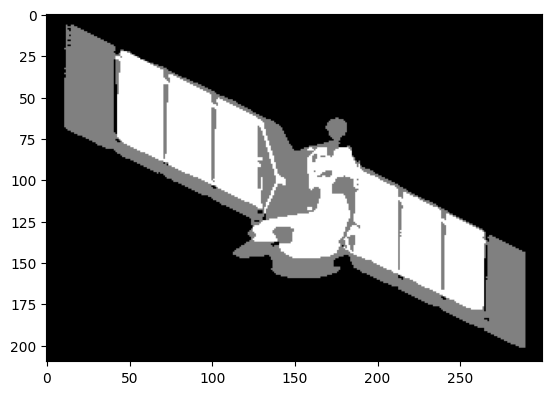

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
best_mse = 1000000
best_image = ""
constant = 5
for i in range(-180, 180, 30):
    for j in range(-90, 90, 30):
        
        # print("Rendering %s %s" % (i, j))
        mse = compare_images("data/images/0b2cada21c/000.png", f"output/0/mesh_{i}_{j}.png", cropping_matrix, constant=constant)
        if mse < best_mse:
            best_mse = mse
            best_image = f"output/0/mesh_{i}_{j}.png"
        print("MSE value for %s %s: %s" % (i, j, mse))

print("Best image", (best_image), "MSE: ", best_mse)


#  plot the best image over the removed background image all in greyscale

img = mpimg.imread("data/images/0b2cada21c/000.png")
# crop image based on cropping matrix with a 
img = img[int(cropping_matrix[0][1]):int(cropping_matrix[1][1]), int(cropping_matrix[0][0]):int(cropping_matrix[1][0])]

# convert to greyscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# convert best_image into same aspect ratio as img by croppping
aspect_ratio = img.shape[1] / img.shape[0]
# reshape so that longest edge is 300
if img.shape[0] < img.shape[1]:
    img = cv2.resize(img, (300, int(300 / aspect_ratio)))
else:
    img = cv2.resize(img, (int(300 * aspect_ratio), 300))
print(img.shape)


# use this aspect ratio to crop the img2
# Calculate the desired width and height based on the aspect ratio
# Calculate the cropping coordinates
img2 = mpimg.imread(best_image)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY_INV)[1]
# img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, constant)
# img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, constant)
# print("Aspect ratio:", aspect_ratio)
# print("Desired width:", desired_width, "Desired height:", desired_height)

crop_x = (img2.shape[1] - desired_width) // 2
crop_y = (img2.shape[0] - desired_height) // 2
# print("Crop x:", crop_x, "Crop y:", crop_y)

# Crop img2
img2_cropped = img2[crop_y:crop_y+desired_height, crop_x:crop_x+desired_width]


# img2_cropped = cv2.cvtColor(img2_cropped, cv2.COLOR_BGR2GRAY)
 # run high pass filter on both images
# kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) # laplacian kernel
# kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]) # prewitt kernel
# img = cv2.filter2D(img, -1, kernel)
# img2_cropped = cv2.filter2D(img2_cropped, -1, kernel)
plt.imshow(img, cmap='gray')

plt.imshow(img2_cropped, cmap='gray', alpha=0.5)
plt.show()